In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math
import traceback
import glob

# Vehicle Trajectories

In [2]:
def plot_vehicle_trajectories(csv_paths, 
                             image_path=None, 
                             image_extent=None,  # [xmin, xmax, ymin, ymax]
                             image_alpha=0.5,
                             colors=None,
                             line_styles=None,
                             save_path=None,
                             figure_size=(14, 12),
                             swap_xy=False,        # Swap x and y axes
                             invert_xaxis=False,   # Invert x-axis
                             invert_yaxis=False,   # Invert y-axis
                             xlim=None,            # Set x-axis limits [min, max]
                             ylim=None,
                             skip_initial_rows=0):
    """
    Plot multiple vehicle trajectories from CSV files with optional image overlay.
    
    Parameters:
    -----------
    csv_paths : list
        List of paths to CSV files containing trajectory data
    image_path : str, optional
        Path to an image file to overlay on the plot (e.g., junction image)
    image_extent : list, optional
        Image extent as [xmin, xmax, ymin, ymax] for positioning the image
    image_alpha : float, optional
        Alpha transparency for the image overlay (0 to 1)
    colors : list, optional
        List of colors for each trajectory (will cycle if fewer than csv_paths)
    line_styles : list, optional
        List of line styles for each trajectory (will cycle if fewer than csv_paths)
    save_path : str, optional
        Path to save the figure (if None, figure is not saved)
    figure_size : tuple, optional
        Size of the figure in inches (width, height)
    
    Returns:
    --------
    fig : matplotlib figure
        The figure object containing the plot
    """
    
    # Default colors and line styles if not provided
    if colors is None:
        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    if line_styles is None:
        line_styles = ['-', '--', '-.', ':']
    
    # Create the figure
    fig, (ax_traj, ax_cte) = plt.subplots(2, 1, figsize=figure_size, gridspec_kw={'height_ratios': [3, 1]})
    
    # Dictionary to store all data for comparing metrics
    all_data = {}
    
    # If image_path is provided, load and display the image
    if image_path and os.path.exists(image_path):
        try:
            img = plt.imread(image_path)
            if image_extent is None:
                # If no extent is provided, use a default centered on the first trajectory
                df_first = pd.read_csv(csv_paths[0])
                x_min, x_max = df_first['vehicle_x'].min(), df_first['vehicle_x'].max()
                y_min, y_max = df_first['vehicle_y'].min(), df_first['vehicle_y'].max()
                x_padding = (x_max - x_min) * 0.1
                y_padding = (y_max - y_min) * 0.1
                image_extent = [x_min - x_padding, x_max + x_padding, 
                                y_min - y_padding, y_max + y_padding]
            
            ax_traj.imshow(img, extent=image_extent, aspect='auto', alpha=image_alpha, zorder=0)
            print(f"Image overlay applied with extent: {image_extent}")
        except Exception as e:
            print(f"Warning: Could not load or display image: {e}")
    
    # Process each CSV file
    for i, csv_path in enumerate(csv_paths):
        # Get color and line style for this trajectory
        color = colors[i % len(colors)]
        line_style = line_styles[i % len(line_styles)]
        
        # Extract file name for legend
        file_name = os.path.basename(csv_path).replace('.csv', '')
        
        try:
            # Load data
            df = pd.read_csv(csv_path)
            # Skip initial rows if requested
            if skip_initial_rows > 0:
                if skip_initial_rows < len(df):
                    df = df.iloc[skip_initial_rows:].reset_index(drop=True)
                    print(f"Skipped {skip_initial_rows} initial rows for {file_name}")
                else:
                    print(f"Warning: skip_initial_rows ({skip_initial_rows}) is larger than dataset size ({len(df)}) for {file_name}")
            
            
            # Store in all_data dictionary
            all_data[file_name] = {
                'df': df,
                'color': color,
                'line_style': line_style
            }
            
            
            # Find junction transitions
            junction_entries = []
            junction_exits = []
            
            for j in range(1, len(df)):
                prev_row = df.iloc[j-1]
                current_row = df.iloc[j]
                
                # Check for junction entry
                if not prev_row['in_junction'] and current_row['in_junction']:
                    junction_entries.append((current_row['vehicle_x'], current_row['vehicle_y'], current_row['tick']))
                
                # Check for junction exit
                if not prev_row['passed_junction'] and current_row['passed_junction']:
                    junction_exits.append((current_row['vehicle_x'], current_row['vehicle_y'], current_row['tick']))
            
            # Store junction transitions
            all_data[file_name]['junction_entries'] = junction_entries
            all_data[file_name]['junction_exits'] = junction_exits
            
            # Find command application points
            command_points = df[df['junction_command_applied'] == True]
            all_data[file_name]['command_points'] = command_points
            
            # Determine which vehicle coordinate to use for each axis based on swap_xy
            x_coord = 'vehicle_y' if swap_xy else 'vehicle_x'
            y_coord = 'vehicle_x' if swap_xy else 'vehicle_y'
            
            # For ideal coordinates, also handle the swap
            plot_ideal_x = 'waypoint_y' if swap_xy else 'waypoint_x'
            plot_ideal_y = 'waypoint_x' if swap_xy else 'waypoint_y'            
            # Plot actual trajectory
            ax_traj.plot(df[x_coord], df[y_coord], 
                   color=color, linestyle=line_style, linewidth=2, 
                   label=f'{file_name} - Actual')
            
            # Plot ideal trajectory
            ax_traj.plot(df[plot_ideal_x], df[plot_ideal_y], 
                   color=color, linestyle='--', linewidth=1.5, alpha=0.7,
                   label=f'{file_name} - Ideal')
            
            # Mark junction entry points
            for x, y, tick in junction_entries:
                plot_x = y if swap_xy else x
                plot_y = x if swap_xy else y
                ax_traj.scatter(plot_x, plot_y, color=color, s=150, marker='D', zorder=5, 
                          label=f'{file_name} - Junction Entry')
            
            # Mark junction exit points
            for x, y, tick in junction_exits:
                plot_x = y if swap_xy else x
                plot_y = x if swap_xy else y
                ax_traj.scatter(plot_x, plot_y, color=color, s=150, marker='s', zorder=5, 
                          label=f'{file_name} - Junction Exit')
            
            # Mark command application points
            ax_traj.scatter(
                command_points[x_coord], command_points[y_coord], 
                color=color, s=80, marker='*', zorder=4, alpha=0.7,
                label=f'{file_name} - Command Applied')
                
            # Plot CTE over time
            ax_cte.plot(df['tick'], df['cte'], color=color, linestyle=line_style, 
                   linewidth=2, label=f'{file_name} - CTE')
            
            # Shade junction areas in CTE plot
            for entry, exit in zip(junction_entries, junction_exits):
                if entry and exit:
                    ax_cte.axvspan(entry[2], exit[2], alpha=0.2, color=color)
            
            # Mark command points in CTE plot
            ax_cte.scatter(
                command_points['tick'], 
                command_points['cte'],
                color=color, marker='o', s=50, alpha=0.7
            )
            
            print(f"Processed {file_name} - {len(df)} points, {len(junction_entries)} junctions")
            
        except Exception as e:
            print(f"Error processing {csv_path}: {e}")
    
    # Trajectory plot settings
    ax_traj.set_title('Vehicle Trajectories with Junction Markers and Ideal Paths', fontsize=16)
    
    # Set axis labels based on swap_xy
    ax_traj.set_xlabel('Y Position' if swap_xy else 'X Position', fontsize=14)
    ax_traj.set_ylabel('X Position' if swap_xy else 'Y Position', fontsize=14)
    
    ax_traj.grid(True, linestyle='--', alpha=0.7)
    ax_traj.axis('equal')  # Equal aspect ratio
    
    # Invert axes if requested
    if invert_xaxis:
        ax_traj.invert_xaxis()
    if invert_yaxis:
        ax_traj.invert_yaxis()
        
    # Set axis limits if provided
    if xlim is not None:
        ax_traj.set_xlim(xlim)
    if ylim is not None:
        ax_traj.set_ylim(ylim)
    
    # CTE plot settings
    ax_cte.set_title('Cross-Track Error (CTE) Over Time', fontsize=16)
    ax_cte.set_xlabel('Tick', fontsize=14)
    ax_cte.set_ylabel('CTE Value', fontsize=14)
    ax_cte.grid(True, linestyle='--', alpha=0.7)
    ax_cte.axhline(y=0, color='black', linestyle='-', alpha=0.3)  # Zero line
    
    # Fix the legends to avoid duplicate entries
    handles, labels = ax_traj.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax_traj.legend(by_label.values(), by_label.keys(), loc='best', fontsize=10)
    
    handles, labels = ax_cte.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax_cte.legend(by_label.values(), by_label.keys(), loc='best', fontsize=10)
    
    # Calculate statistics for all runs
    stats_text = "Run Statistics:\n" + "-" * 25 + "\n"
    for name, data in all_data.items():
        df = data['df']
        stats_text += f"{name}:\n"
        stats_text += f"  Points: {len(df)}\n"
        stats_text += f"  Commands: {len(data['command_points'])}\n"
        stats_text += f"  In junction: {df['in_junction'].sum()} ticks\n"
        
        # Calculate average CTE
        cte_values = df['cte'].abs()  # Use absolute CTE for average
        avg_cte = cte_values.mean()
        max_cte = cte_values.max()
        stats_text += f"  Avg. |CTE|: {avg_cte:.3f}, Max |CTE|: {max_cte:.3f}\n"
        
        # Junction timings
        if data['junction_entries'] and data['junction_exits']:
            entry_tick = data['junction_entries'][0][2]
            exit_tick = data['junction_exits'][0][2]
            stats_text += f"  Junction: {entry_tick} → {exit_tick} ({exit_tick - entry_tick} ticks)\n"
        stats_text += "\n"
    
    # Add stats text to the figure
    plt.figtext(0.02, 0.02, stats_text, fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
    
    # Adjust layout
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.2)  # Make room for the stats text
    
    # Save the figure if requested
    if save_path:
        #plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Figure saved to {save_path}")
    
    return fig



Skipped 40 initial rows for run_1
Processed run_1 - 64 points, 1 junctions


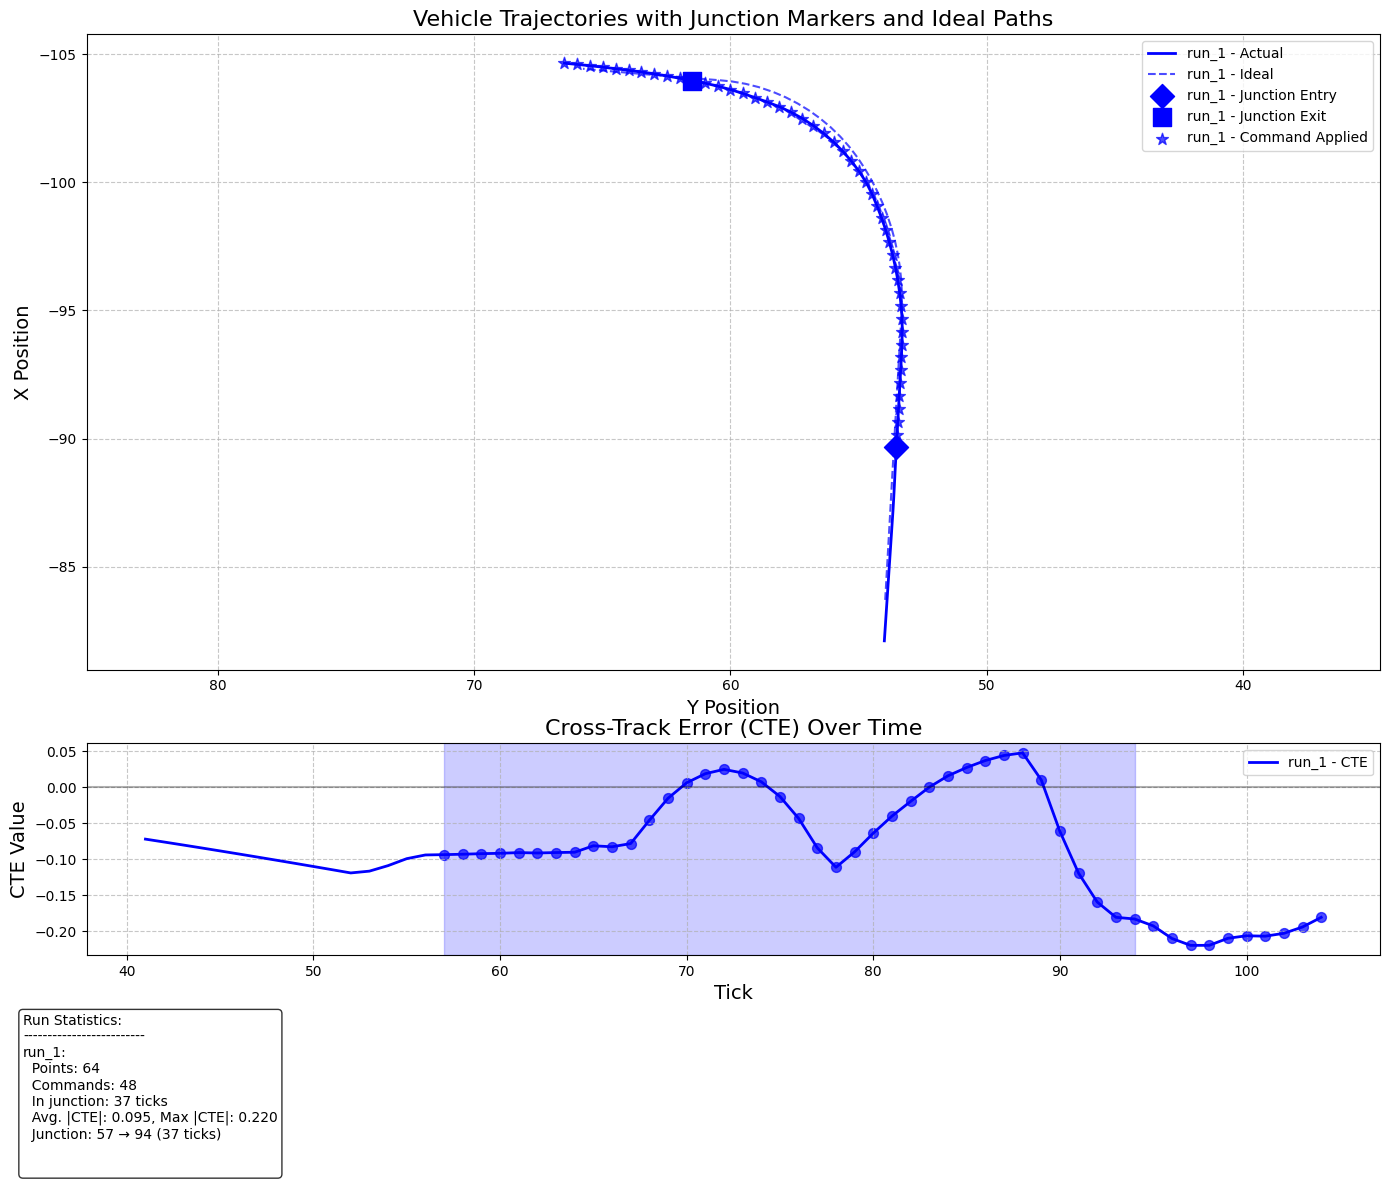

Figure saved to trajectory_plot.png


In [3]:

# List of CSV files to plot
csv_files = ['/home/luca/carla/source/results/MH-0/town07_left_junction_timing/junction_timing_results/command_LEFT/delay_0/duration_0/run_1.csv',
            ]

# Optional image path for junction overlay (if you have one)
junction_image = None#"/home/luca/Desktop/carla_town7_junction.png"  # 'junction_map.png'

# Call the function
fig = plot_vehicle_trajectories(
    csv_paths=csv_files,
    image_path=junction_image,
    # If you have an image, set the extent to position it correctly:
    #image_extent=[-95, -70, 40, 60],  # [xmin, xmax, ymin, ymax]
    image_alpha=0.5,
    figure_size=(14, 12),
    save_path='trajectory_plot.png',  # Optional: save the figure
    swap_xy=True,        # Set to True to swap X and Y coordinates
    invert_xaxis=True,   # Set to True to invert X axis
    invert_yaxis=True,   # Set to True to invert Y axis
    xlim=None,            # Set custom X axis limits, e.g., [-100, -70]
    ylim=None,             # Set custom Y axis limits, e.g., [40, 60]
    skip_initial_rows=40
)

plt.show()


# HeatMaps

In [4]:
def create_enhanced_heatmaps(csv_file_path, results_dir, failure_df=None, model_key="", scenario_type="right", title_ext=""):
    """
    Reads CSV data and creates enhanced heatmaps with failure type information.
    
    Args:
        csv_file_path (str): Path to the CSV file containing the data.
        results_dir (str): Directory where the heatmap images will be saved.
        failure_df (DataFrame, optional): DataFrame containing failure analysis results.
        model_key (str, optional): Key to identify model version in output filename.
        scenario_type (str, optional): "right" or "left" to specify which junction scenario is being analyzed
    """
    # Read CSV data
    all_params = pd.read_csv(csv_file_path)
    
    # Filter to get only the commands with at least one successful outcome
    perfect_params = all_params[all_params['success'] == 1]
    
            # Define failure type colors (matching the bar chart colors)
    failure_colors = {
        'exceeded_cte_and_completed_turn': '#D5E5F2',  # Pastel blue
        'exceeded_cte_and_continued_straight': '#FFC29A',  # Pastel orange
        'exceeded_cte_and_continued_left': '#FFE8C2',  # Pastel red/pink
        'exceeded_cte_and_continued_right': '#FFE8C2',  # Pastel purple
        'otherwise_exceeded_cte': '#CCCCCC',  # Light gray
        'hit_obstacle': '#CEA5DF',  # Pastel pink
        'not_exceeded_cte_and_completed_turn': '#FFF8B5',  # Light yellow
        'not_exceeded_cte_and_continued_straight': '#BFEFFF',  # Light blue
        'not_exceeded_cte_and_continued_left': '#FCF3CF',  # Light yellow/orange
        'not_exceeded_cte_and_continued_right': '#D4EFDF',  # Light green
    }
    
    # Loop through unique commands in perfect_params
    for command in perfect_params['command_tested'].unique():
        # Skip if no duration testing
        if 'command_duration' not in perfect_params.columns:
            continue
            
        # Get all data for this command
        cmd_data = all_params[all_params['command_tested'] == command]
        
        # Create a figure with two subplots (heatmap on top, bar chart on bottom)
        fig, (ax_heatmap, ax_bar) = plt.subplots(2, 1, figsize=(14, 10), 
                                               gridspec_kw={'height_ratios': [3, 0.2]}, 
                                               constrained_layout=True)
        
        # Get unique values for axes
        delays = sorted(cmd_data['tick_delay'].unique())
        # Custom ordering of durations to put 0 (Junction End) on the right
        durations = sorted(cmd_data['command_duration'].unique())
        if 0 in durations:
            # Remove 0 from the list and append it at the end
            durations.remove(0)
            durations.append(0)
        
        # Create matrices for heatmap data
        success_matrix = np.zeros((len(delays), len(durations)))
        failure_type_matrix = np.empty((len(delays), len(durations)), dtype=object)
        for i in range(len(delays)):
            for j in range(len(durations)):
                failure_type_matrix[i, j] = 'unknown'
                
        # Counters for the bar chart
        outcome_counts = {'success': 0}
        for ft in failure_colors:
            outcome_counts[ft] = 0
            
        # Fill in the success matrix and get run IDs for failures
        run_id_matrix = np.empty((len(delays), len(durations)), dtype=object)
        
        for i, delay in enumerate(delays):
            for j, duration in enumerate(durations):
                mask = (cmd_data['tick_delay'] == delay) & (cmd_data['command_duration'] == duration)
                if mask.any():
                    row = cmd_data[mask].iloc[0]
                    success_val = row['success']
                    
                    # Create a synthetic run_id if it doesn't exist in the data
                    if 'run_id' in row:
                        run_id = row['run_id']
                    else:
                        # Create a unique identifier using delay, duration and perhaps index
                        run_id = f"{command}_{delay}_{duration}_{i}_{j}"
                    
                    run_id_matrix[i, j] = run_id
                    
                    success_matrix[i, j] = success_val
                    
                    if success_val == 1:
                        outcome_counts['success'] += 1
                        failure_type_matrix[i, j] = 'success'
        
        # If we have failure analysis data, match it to failures in our matrix
        if failure_df is not None and not failure_df.empty:
            for i, delay in enumerate(delays):
                for j, duration in enumerate(durations):
                    if success_matrix[i, j] == 0:  # This is a failure
                        run_id = run_id_matrix[i, j]
                        
                        # Find this run in the failure_df by matching parameters instead of run_id
                        # First try by run_id
                        failure_info = failure_df[failure_df['run_id'] == run_id]
                        
                        # If no match found, try matching by parameters
                        if failure_info.empty:
                            parameter_mask = (
                                (failure_df['command_tested'] == command) &
                                (failure_df['tick_delay'] == delay) &
                                (failure_df['command_duration'] == duration)
                            )
                            failure_info = failure_df[parameter_mask]
                        if not failure_info.empty:
                            failure_type = failure_info.iloc[0]['failure_type']
                            failure_type_matrix[i, j] = failure_type
                            outcome_counts[failure_type] = outcome_counts.get(failure_type, 0) + 1
                        else:
                            outcome_counts['unknown'] = outcome_counts.get('unknown', 0) + 1
        
        # Create heatmap with custom coloring for failure types
        ax_heatmap.imshow(np.zeros((len(delays), len(durations))), cmap='Greys', alpha=0.1)  # Very light base
        
        # Draw cell borders and add symbols/colors
        for i in range(len(delays)):
            for j in range(len(durations)):
                # Add cell border
                rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, 
                                   edgecolor='black', linewidth=0.5)
                ax_heatmap.add_patch(rect)
                
                if success_matrix[i, j] == 1.0:
                    # Success case - green background and checkmark
                    success_rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, 
                                              color='#c8f7c8', alpha=0.8)
                    ax_heatmap.add_patch(success_rect)
                    ax_heatmap.text(j, i, "✓", ha='center', va='center', fontsize=20, 
                                 color='#2CA02C', fontweight='bold')
                else:
                    # Failure case - color based on failure type
                    failure_type = failure_type_matrix[i, j]
                    color = failure_colors.get(failure_type, None)
                    failure_rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, 
                                              color=color, alpha=0.7)
                    ax_heatmap.add_patch(failure_rect)
                    ax_heatmap.text(j, i, "✗", ha='center', va='center', fontsize=20, 
                                 color='#931621', fontweight='bold')
        
        # Set ticks with special handling for duration=0
        duration_labels = []
        for dur in durations:
            if dur == 0:
                duration_labels.append("Until\nJunction End")
            else:
                duration_labels.append(str(dur))
        ax_heatmap.set_xticks(range(len(durations)))
        ax_heatmap.set_xticklabels(duration_labels)
        ax_heatmap.set_yticks(range(len(delays)))
        ax_heatmap.set_yticklabels(delays)
        
        # Add labels to heatmap
        ax_heatmap.set_xlabel('Command Duration / 100ms')
        ax_heatmap.set_ylabel('Command Delay / 100ms')
        ax_heatmap.set_title(f'{command} Command Outcomes by Delay and Duration')
        
        # Add axis styling
        for spine in ax_heatmap.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2)
        
        # Create the bar chart of outcome types
        outcome_types = []
        outcome_values = []
        bar_colors = []
        
        # Add success first
        outcome_types.append('Success')
        outcome_values.append(outcome_counts['success'])
        bar_colors.append('#c8f7c8')  # Success color
        
        # Define nice labels for failure types based on scenario type
        failure_labels = {
            'exceeded_cte_and_completed_turn': 'Exceeded CTE & Completed Turn',
            'exceeded_cte_and_continued_straight': 'Continued Straight',
            'otherwise_exceeded_cte': 'Otherwise',
            'hit_obstacle': 'Collision',
        }
        
        # Add specific labels for continued left/right based on scenario type
        if scenario_type == "right":
            failure_labels['exceeded_cte_and_continued_left'] = 'Continued Left'
            failure_labels['exceeded_cte_and_continued_right'] = 'Completed Turn'  # Include but we'll filter out duplicates
        elif scenario_type == "left":
            failure_labels['exceeded_cte_and_continued_right'] = 'Continued Right'
            failure_labels['exceeded_cte_and_continued_left'] = 'Completed Turn'  # Include but we'll filter out duplicates
        
        # Define the order we want failure types to appear in
        failure_type_order = [
            'exceeded_cte_and_completed_turn',
            'exceeded_cte_and_continued_straight',
        ]
        
        # Add the scenario-specific type (left or right) in the correct position
        if scenario_type == "right":
            failure_type_order.append('exceeded_cte_and_continued_left')
        elif scenario_type == "left":
            failure_type_order.append('exceeded_cte_and_continued_right')
            
        # Complete the ordering
        failure_type_order.extend([
            'hit_obstacle',
            'otherwise_exceeded_cte',
            'unknown'
        ])
        
        # Add failure types in the specified order (even if count is zero)
        for ft in failure_type_order:
            if ft in failure_labels:
                label = failure_labels.get(ft)
                count = outcome_counts.get(ft, 0)
                outcome_types.append(label)
                outcome_values.append(count)
                bar_colors.append(failure_colors[ft])
        
        # Calculate total number of experiments for this command
        total_experiments = sum(outcome_values)
        
        # Success should be first (leftmost), then failure types
        # Reorder outcomes to ensure Success is first
        ordered_outcomes = []
        ordered_values = []
        ordered_colors = []
        
        # First add success
        success_idx = outcome_types.index('Success') if 'Success' in outcome_types else -1
        if success_idx >= 0:
            ordered_outcomes.append(outcome_types[success_idx])
            ordered_values.append(outcome_values[success_idx])
            ordered_colors.append(bar_colors[success_idx])
        
        # Then add failure types
        for i, outcome in enumerate(outcome_types):
            if outcome != 'Success':
                ordered_outcomes.append(outcome)
                ordered_values.append(outcome_values[i])
                ordered_colors.append(bar_colors[i])
        
        # Clear the previous bar chart
        ax_bar.clear()
        
        # Track the left edge of each segment
        left = 0
        
        # Store the segments for the legend mapping
        segment_to_label = {}
        
        # Create segments in order
        for outcome, value, color in zip(ordered_outcomes, ordered_values, ordered_colors):
            # Create a segment of the bar (even for zero values)
            segment = ax_bar.barh(0, max(value, 0.1), left=left, height=0.2, color=color)
            segment_to_label[segment] = outcome
            
            # Add text with count and percentage for all segments
            percentage = (value / total_experiments) * 100 if total_experiments > 0 else 0
            
            # Add text for all segments with different positioning for small ones
            if percentage > 3:
                # Normal segments with text in the center
                ax_bar.text(left + value/2, 0, 
                        f'{int(value)}\n({percentage:.1f}%)', 
                        ha='center', va='center', fontweight='bold', fontsize=11)
            
            # Move left edge for next segment (ensure at least a small width for visualization)
            left += max(value, 0.1)
        
        # Remove y-axis ticks and labels
        ax_bar.set_yticks([])
        ax_bar.set_yticklabels([])
        
        # Set appropriate x-axis
        ax_bar.set_xlim(0, total_experiments)
        
        # Add labels to bar chart
        ax_bar.set_xlabel('Number of Experiments', fontsize=12)
        ax_bar.set_title(f'Outcome Distribution for {command} Command', fontsize=14)
        
        # Add percentage scale on top
        ax2 = ax_bar.twiny()
        ax2.set_xlim(0, 100)
        ax2.set_xlabel('Percentage (%)', fontsize=12)
        
        # Add a thin grid for better readability
        ax_bar.grid(axis='x', linestyle='--', alpha=0.3)
        
        # Create legend elements in the specific order
        legend_elements = [
            Patch(facecolor='#c8f7c8', label='Success'),
        ]
        
        # Add the failure types in the same order as the bar chart
        for ft in failure_type_order:
            if ft in failure_labels and ft in failure_colors:
                legend_elements.append(Patch(facecolor=failure_colors[ft], label=failure_labels[ft]))
                
        # Ensure we always have exactly 7 entries in the legend
        while len(legend_elements) < 7:
            # Add placeholder entries if needed
            legend_elements.append(Patch(facecolor='#FFFFFF', label='', alpha=0))
        
        # Place a common legend below both charts
        fig.legend(handles=legend_elements, loc='lower center', 
                  bbox_to_anchor=(0.51, -0.1), ncol=min(len(legend_elements), 5), 
                  fontsize=12, frameon=True)
        
        # Add a figure title that spans both subplots
        scenario_desc = "Right Turn" if scenario_type == "right" else "Left Turn"
        fig.suptitle(f'Performance Analysis - {scenario_desc} Scenario - {title_ext}', 
                     fontsize=16, fontweight='bold', y=0.98)
        
        # Add detailed stats for all categories in text form
        stats_text = f"Total experiments: {total_experiments}"
        
        # Add percentages for all categories
        if total_experiments > 0:
            for ft, label in [('success', 'Success')] + [(ft, failure_labels[ft]) for ft in failure_type_order if ft in failure_labels]:
                count = outcome_counts.get(ft, 0)
                rate = (count / total_experiments) * 100
                stats_text += f" | {label}: {rate:.1f}%"
                
        fig.text(0.033, -0.02, stats_text, fontsize=10, ha='left')
        
        # Adjust spacing between subplots and make room for the legend
        plt.subplots_adjust(hspace=0.4, bottom=0.15)
        
        # Save high-res versions
        output_filename = f"enhanced_heatmap_{command}_{scenario_type}_{model_key}.pdf"
        plt.savefig(os.path.join(results_dir, output_filename), bbox_inches='tight')
        plt.show()
        plt.close(fig)

    print(f"Enhanced heatmaps with failure types created successfully for {scenario_type} scenario!")

In [5]:
def analyze_single_failure(df: pd.DataFrame, cte_threshold: float,                            
                          finishing_threshhold: float,
                          alternative_threshhold: float,
                          finish_checkpoint_coords: tuple = None,
                          alternative_checkpoint_coords: tuple = None,
                          left_checkpoint_coords: tuple = None,
                          right_checkpoint_coords: tuple = None):
    """
    Analyze a single failed run to determine failure type.
    
    Parameters:
    -----------
    df : DataFrame
        Run data from CSV
    cte_threshold : float
        Threshold for considering CTE as excessive
    finish_checkpoint_coords : tuple, optional
        (x, y) coordinates of the finish point (success if vehicle comes within 1m)
    alternative_checkpoint_coords : tuple, optional
        (x, y) coordinates of a checkpoint the vehicle should pass if going straight (within 3m)
    left_checkpoint_coords : tuple, optional
        (x, y) coordinates of a checkpoint if the vehicle goes left (within 3m)
    right_checkpoint_coords : tuple, optional
        (x, y) coordinates of a checkpoint if the vehicle goes right (within 3m)
    
    Returns:
    --------
    Dictionary with failure analysis results
    """
    # Default values
    results = {
        'failure_type': 'unknown',
        'max_cte': df['max_cte_during_run'] if 'max_cte_during_run' in df.columns else df['cte'].abs().max(),
        'max_cte_tick': df.loc[df['cte'].abs().idxmax(), 'tick'],
        'completed_turn': False,
        'hit_obstacle': False,
        'continued_straight': False,
        'continued_left': False,
        'continued_right': False,
        'reached_waypoint': False,
        'min_speed': df['speed'].min() if 'speed' in df.columns else None,
    }

    # Check if CTE exceeded threshold at any point
    exceeded_cte = df['cte'].abs().max() >= cte_threshold
    
    # Check if vehicle passed near the alternative checkpoint (continued straight)
    if alternative_checkpoint_coords is not None and 'vehicle_x' in df.columns and 'vehicle_y' in df.columns:
        checkpoint_x, checkpoint_y = alternative_checkpoint_coords
        
        # Calculate minimum distance to checkpoint for any point in the trajectory
        distances = np.sqrt((df['vehicle_x'] - checkpoint_x)**2 + (df['vehicle_y'] - checkpoint_y)**2)
        min_distance = distances.min()
        results['min_distance_to_alternative'] = min_distance
        
        # If any point in the trajectory was within threshold of the alternative checkpoint,
        # consider that the vehicle continued straight
        if min_distance < alternative_threshhold:
            results['continued_straight'] = True
            results['reached_waypoint'] = True
    
    # Check if vehicle passed near the left checkpoint
    if left_checkpoint_coords is not None and 'vehicle_x' in df.columns and 'vehicle_y' in df.columns:
        left_x, left_y = left_checkpoint_coords
        
        # Calculate minimum distance to left checkpoint for any point in the trajectory
        left_distances = np.sqrt((df['vehicle_x'] - left_x)**2 + (df['vehicle_y'] - left_y)**2)
        min_left_distance = left_distances.min()
        results['min_distance_to_left'] = min_left_distance
        
        # If any point in the trajectory was within threshold of the left checkpoint
        if min_left_distance < alternative_threshhold:
            results['continued_left'] = True
            results['reached_waypoint'] = True

    # Check if vehicle passed near the right checkpoint
    if right_checkpoint_coords is not None and 'vehicle_x' in df.columns and 'vehicle_y' in df.columns:
        right_x, right_y = right_checkpoint_coords
        
        # Calculate minimum distance to right checkpoint for any point in the trajectory
        right_distances = np.sqrt((df['vehicle_x'] - right_x)**2 + (df['vehicle_y'] - right_y)**2)
        min_right_distance = right_distances.min()
        results['min_distance_to_right'] = min_right_distance
        
        # If any point in the trajectory was within threshold of the right checkpoint
        if min_right_distance < alternative_threshhold:
            results['continued_right'] = True
            results['reached_waypoint'] = True

    # Check if vehicle reached finish checkpoint
    if finish_checkpoint_coords is not None and 'vehicle_x' in df.columns and 'vehicle_y' in df.columns:
        finish_x, finish_y = finish_checkpoint_coords
        
        # Calculate minimum distance to finish for any point in the trajectory
        distances = np.sqrt((df['vehicle_x'] - finish_x)**2 + (df['vehicle_y'] - finish_y)**2)
        min_distance = distances.min()
        results['min_distance_to_finish'] = min_distance
        
        # If any point in the trajectory was within threshold of the finish checkpoint,
        # consider that the vehicle completed the turn
        if min_distance < finishing_threshhold:
            results['completed_turn'] = True
    
    # Check for hitting obstacles based ONLY on speed threshold
    if 'speed' in df.columns:        
        # Find first index where speed exceeds N
        start_idx = df[df['speed'] > 4.0].index[0] if any(df['speed'] > 4.0) else None
        
        # Check if speed drops below N m/s after the start
        if start_idx is None:
            results['hit_obstacle'] = True
        elif not df.iloc[start_idx:].empty:
            min_speed_after_start = df.iloc[start_idx:]['speed'].min()
            results['min_speed_after_start'] = min_speed_after_start
            
            if min_speed_after_start < 3.0:
                results['hit_obstacle'] = True
    
    # Determine failure type based on analysis
    if results['hit_obstacle']:
        results['failure_type'] = 'hit_obstacle'
    elif exceeded_cte:
        if results['completed_turn']:
            results['failure_type'] = 'exceeded_cte_and_completed_turn'
        elif results['continued_straight']:
            results['failure_type'] = 'exceeded_cte_and_continued_straight'
        elif results['continued_left']:
            results['failure_type'] = 'exceeded_cte_and_continued_left'
        elif results['continued_right']:
            results['failure_type'] = 'exceeded_cte_and_continued_right'
        else:
            results['failure_type'] = 'otherwise_exceeded_cte'
    elif not exceeded_cte: # kind of misleading, some cases end up here, because they reached the end point within 2m, but since thats officialy failed, they get also sorted to failures
        if results['completed_turn']:
            results['failure_type'] = 'exceeded_cte_and_completed_turn'
        elif results['continued_straight']:
            results['failure_type'] = 'exceeded_cte_and_continued_straight'
        elif results['continued_left']:
            results['failure_type'] = 'exceeded_cte_and_continued_left'
        elif results['continued_right']:
            results['failure_type'] = 'exceeded_cte_and_continued_right'
        else:
            results['failure_type'] = 'otherwise_not_exceeded_cte'
    else:
        results['failure_type'] = 'unknown'
    
    return results

def analyze_failure_cases(results_dir: str, cte_threshold: float = 2.0,
                          finishing_threshhold: float = 2.0,
                          alternative_threshhold: float = 2.0,
                          finish_checkpoint_coords: tuple = None,
                          alternative_checkpoint_coords: tuple = None,
                          left_checkpoint_coords: tuple = None,
                          right_checkpoint_coords: tuple = None):
    """
    Analyze failed junction navigation runs to categorize failure types.
    
    Parameters:
    -----------
    results_dir : str
        Directory containing experiment results
    cte_threshold : float
        Threshold for considering CTE as excessive
    finishing_threshhold : float
        Threshold distance for considering finish point reached
    alternative_threshhold : float
        Threshold distance for considering alternative checkpoint reached
    finish_checkpoint_coords : tuple, optional
        (x, y) coordinates of the finish point (success if vehicle comes within threshold)
    alternative_checkpoint_coords : tuple, optional
        (x, y) coordinates of a checkpoint the vehicle should pass if going straight
    left_checkpoint_coords : tuple, optional
        (x, y) coordinates of a checkpoint if the vehicle goes left
    right_checkpoint_coords : tuple, optional
        (x, y) coordinates of a checkpoint if the vehicle goes right
    
    Returns:
    --------
    DataFrame with failure analysis results
    """
    # Load summary data
    summary_path = os.path.join(results_dir, "results_summary.csv")
    if not os.path.exists(summary_path):
        print(f"Error: Could not find results summary at {summary_path}")
        return None
    
    summary_df = pd.read_csv(summary_path)
    
    # Filter failed runs
    failed_runs = summary_df[summary_df['success'] == False]
    if failed_runs.empty:
        print("No failed runs found in the data.")
        #return pd.DataFrame()
    
    print(f"Found {len(failed_runs)} failed runs to analyze.")
    
    # Results container
    failure_analysis = []
    
    # Find and analyze each failed run
    for _, run in failed_runs.iterrows():
        run_id = run['run_id']
        command = run['command_tested']
        duration = run['command_duration']
        delay = run['tick_delay']
        
        # Find the CSV file for this run
        run_files = []
        
        # Search in potential subdirectories based on command structure
        search_patterns = [
            f"**/command_{command}/delay_{delay}/duration_{duration}/run_*.csv"]
        
        for pattern in search_patterns:
            run_files.extend(glob.glob(os.path.join(results_dir, pattern), recursive=True))
        
        if not run_files:
            print(f"Warning: Could not find CSV file for run {run_id}")
            continue
        
        # Find the most likely match if multiple files found
        run_file = run_files[0]  # Default to first match
        
        # Load run data
        run_df = pd.read_csv(run_file)

        # Analyze failure type
        failure_info = analyze_single_failure(
            run_df, 
            cte_threshold, 
            finishing_threshhold,
            alternative_threshhold,
            finish_checkpoint_coords=finish_checkpoint_coords,
            alternative_checkpoint_coords=alternative_checkpoint_coords,
            left_checkpoint_coords=left_checkpoint_coords,
            right_checkpoint_coords=right_checkpoint_coords
        )

        # Debug output for specific failure types if needed
        #if failure_info['failure_type'] in ['exceeded_cte_and_continued_left', 'exceeded_cte_and_continued_right']:
         #   print(f"Found {failure_info['failure_type']}: command {command} delay {delay} duration {duration} runID {run_id}")
        
        # Add run metadata
        failure_info.update({
            'run_id': run_id,
            'command_tested': command,
            'tick_delay': delay,
            'command_duration': run.get('command_duration', 0),
            'csv_file': os.path.basename(run_file)
        })
        
        failure_analysis.append(failure_info)
        
    # Convert to DataFrame
    if failure_analysis:
        failure_df = pd.DataFrame(failure_analysis)
        
        # Save results
        failure_df.to_csv(os.path.join(results_dir, "failure_analysis.csv"), index=False)
        
        # Print summary of failure types
        print("\nFailure Type Summary:")
        type_counts = failure_df['failure_type'].value_counts()
        for failure_type, count in type_counts.items():
            print(f"  {failure_type}: {count}")
        
        return failure_df
    else:
        print("No failure data could be analyzed.")
        return pd.DataFrame()

Found 161 failed runs to analyze.

Failure Type Summary:
  hit_obstacle: 158
  exceeded_cte_and_continued_straight: 3


/tmp/ipykernel_67374/3166154220.py:330: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, bottom=0.15)


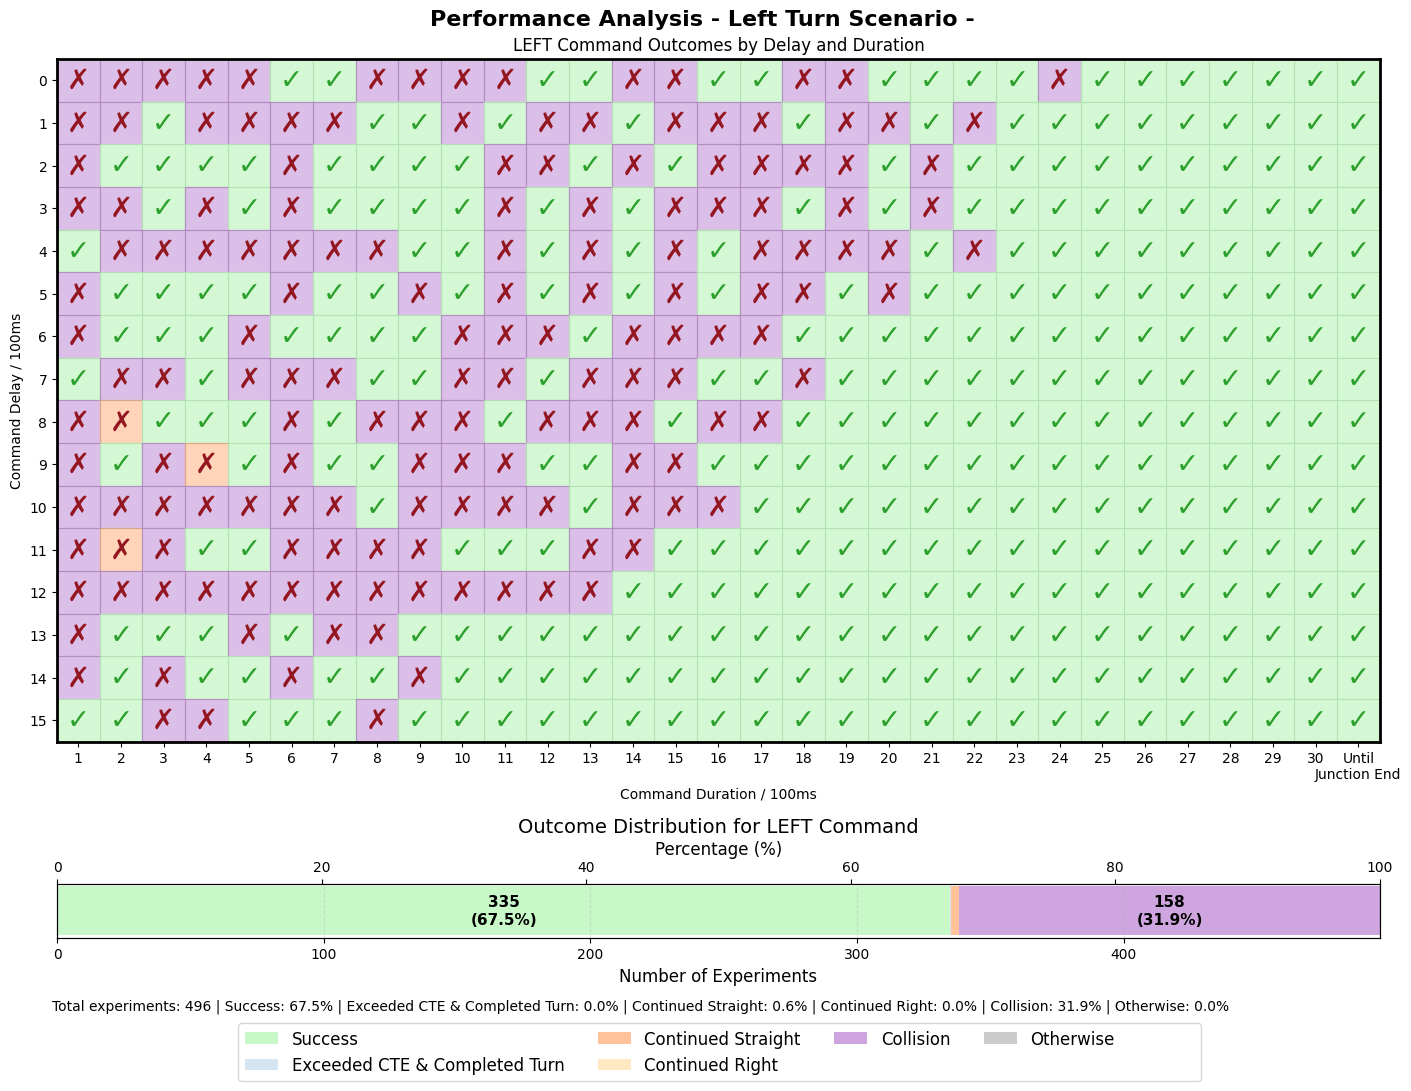

Enhanced heatmaps with failure types created successfully for left scenario!
Enhanced heatmaps with failure types created successfully!


In [7]:
# Example usage of the enhanced visualization:
base_path = "/home/luca/carla/source/results/MH-0/town07_left_junction_timing/junction_timing_results"
csv_file_path = base_path + '/success_rates.csv'

# First, run the failure analysis (if not already done)
alternative_straight = (-114.8460922241211, 49.13320541381836)
alternative_left = (-104.43624877929688, 65.75297546386719)
alternative_right = (-99.49116516113281, 38.684383392333984)



# This should reuse your existing analyze_failure_cases function
failure_results = analyze_failure_cases(
    results_dir=base_path,
    cte_threshold=2.0,
    finishing_threshhold=2.0,
    alternative_threshhold=2.0,
    finish_checkpoint_coords=alternative_right,
    alternative_checkpoint_coords=alternative_straight,
    left_checkpoint_coords = alternative_left,
    right_checkpoint_coords = alternative_right
)


# Now create the enhanced heatmaps with failure type information
create_enhanced_heatmaps(csv_file_path, base_path, failure_df=failure_results, model_key="", scenario_type="left")

print("Enhanced heatmaps with failure types created successfully!")